In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Embedding,GlobalMaxPooling1D
from keras.layers import Dropout
from keras.layers import Convolution1D
from keras.layers import Flatten
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.convolutional import MaxPooling2D,MaxPooling1D

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix,classification_report

import re
import unidecode
import nltk
from datetime import datetime

In [58]:
def get_time_info(df):
    # Time information transformed into hour of the day + day of the week one-hot encoding matrices
    tweet_created = pd.to_datetime(df['tweet_created'])
    hoursday = tweet_created.dt.hour
    weekday = tweet_created.dt.dayofweek

    # One-hot encoding for 'hoursday' and 'weekday'
    hour1hot = pd.get_dummies(hoursday,prefix='h',columns=list(range(24)))
    weekday1hot = pd.get_dummies(weekday,prefix='wd',columns=list(range(7)))
    return hour1hot

# Extract emojis from text
from emoji import UNICODE_EMOJI #pip install emoji

def emoji_shortname(patterns,thelist):
    elist = []
    for pattern in patterns:
        for emoji in thelist:
            match = re.search(pattern,emoji)
            if match: elist.append(emoji)
    return elist

def get_emoji_img(mydict,emojiShortname):
    ## Extract unicode emoji images based on the selected shortnames
    return list(mydict.keys())[list(mydict.values()).index(emojiShortname)]

def in_emoji(tweet,emojilist):
    emo = 0
    inemoji = []
    for emoji in emojilist:
        match = tweet.find(emoji)
        if match != -1: inemoji.append(emoji)
    if(len(inemoji) >=1): emo = 1
    return emo 

def get_emoji(df):
    # List of UNICODE emojis
    unicodeemojilist = list(UNICODE_EMOJI.values())

    # Regular expressions to cast negative emoji in the list of Unicode Emoji
    negative_patterns = [re.compile(r'.*frown.*(face)'),re.compile(r'confounded'),re.compile(r'disappoint'),
                     re.compile(r'worried'),re.compile(r'crying'),re.compile(r'\bang[er][ry]'),re.compile(r'fear'),
                     re.compile(r'weary'),re.compile(r'exploding_face'),re.compile(r'grimacing'),
                     re.compile(r'face_with_steam_from_nose'),re.compile(r'pouting_face'),re.compile(r'sleepy_face'),
                     re.compile(r'downcast_face_with_sweat'),re.compile(r'unamused_face'),
                     re.compile(r'see-no-evil_monkey'),re.compile(r'pensive_face'),re.compile(r'persevering_face'),
                     re.compile(r'anxi'),re.compile(r'scream'),re.compile(r'hot_face'),re.compile(r'flushed'),
                     re.compile(r'zany_face'),re.compile(r'dizzy.*(face)'),re.compile(r'face_with_symbols_on_mouth'),
                     re.compile(r'thumbs_down:'),re.compile(r'middle_finger:'),re.compile(r'broken_heart')]
    # Regular expressions to cast positive emoji in the list of Unicode Emoji
    positive_patterns = [re.compile(r'grin'),re.compile(r'joy'),re.compile(r'smil'),re.compile(r'kiss:'),re.compile(r'wink'),
           re.compile(r'savoring_food'),re.compile(r'[^broken|couple_with]\wheart'),re.compile(r'thumbs_up:'),
           re.compile(r'OK_hand:'),re.compile(r'clapping_hands:'),re.compile(r'waving_hand:'),
           re.compile(r'raised_hand:'),re.compile(r':relieved_face')]    
                
    # List of negative/positive emojis shortnames
    negative_emoji_shortname = emoji_shortname(negative_patterns,unicodeemojilist)
    positive_emoji_shortname = emoji_shortname(positive_patterns,unicodeemojilist)

    # List of negative/positive emojis
    nlist = []
    for emoji in negative_emoji_shortname:
        nlist.append(get_emoji_img(UNICODE_EMOJI,emoji)) 
    plist = []
    for emoji in positive_emoji_shortname:
        plist.append(get_emoji_img(UNICODE_EMOJI,emoji)) 
    
    # Save the number of positive and negative emojis in two new columns
    emopos = df['text'].apply(in_emoji,emojilist=plist)
    emoneg = df['text'].apply(in_emoji,emojilist=nlist)
    
    emoji1hot = pd.DataFrame({'emopos':emopos,'emoneg':emoneg})
    #emoji1hot.emopos.sum()
    return emoji1hot

import unidecode #pip install unidecode
import string

def basicCleaning(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Delete URLs www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Remove accents
    tweet = unidecode.unidecode(tweet)
    #Delete via, rt and by
    tweet = re.sub(r'\b(rt|via|by)\b','',tweet)
    # Remove numbers
    tweet = re.sub(r'\d+','',tweet)
    # Remove single characters
    tweet = re.sub(r'\b\w\b','',tweet)
    # Remove email addresses
    tweet = re.sub(r'\w*@\w*','',tweet)
    #Remove additional white spaces
    tweet = re.sub('\s+', ' ', tweet)
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
    return tweet

def moreCleaning(tweet):
    #Delete @usernames
    #tweet = re.sub('@[^\s]+','',tweet)
    #Delete #hashtags
    tweet = re.sub('#[^\s]+','',tweet)
    # Remove punctuation (includes @, \ and #)
    regex = re.compile('[%s]' % re.escape(string.punctuation+u"¡"+u"¿"+u"€"))
    tweet = re.sub(regex,'',tweet)
    #Remove additional white spaces
    tweet = re.sub('\s+', ' ', tweet)
    return tweet

def extract_airline(tweet):
    airlinesList = ['aena','aeromar','aeromexico','aireuropa','airmadrid','airnostrum','americanairlines',
         'avianca','blueair','britishairways','easyjet','emirates','iberia','klm',
         'lufthansa','niki','norwegian','qatar','ryanair','spanair','spiritairlines',
         'tame','vasp','vueling','westjet','wizzair']
    patterns = [re.compile(r'aena'),re.compile(r'aeromar?'),
            re.compile(r'aeromexi?c?o?'),re.compile(r'air\s?europ?a?'),
            re.compile(r'airmadr?i?d?'),re.compile(r'airnostru?m?'),
            re.compile(r'american\s?air?l?i?n?e?s?'),re.compile(r'avianca'),re.compile(r'blueai?r?'),
            re.compile(r'british\s?a?i?r?w?a?y?s?'),re.compile(r'easyjet'),
            re.compile(r'emitares'),
            re.compile(r'ibe?r?i?a?'),re.compile(r'klm'),
            re.compile(r'lufthansa'),re.compile(r'niki'),re.compile(r'norwegian'),
            re.compile(r'quatara?i?r?'),re.compile(r'ryanai?r?'),
            re.compile(r'spanai?r?'),re.compile(r'spiritairl?i?n?e?s?'),
            re.compile(r'tame'),re.compile(r'vasp'),
            re.compile(r'vueling'),re.compile(r'westjet'),re.compile(r'wizza?i?r?')]
      
    noms = str()
    i = 0
    for airline in patterns:
        match = re.search(airline, tweet)
        if match : noms = noms+'|'+airlinesList[i]
        i = i + 1
    if (len(noms) == 0): 
        noms = 'noairline'
    else:
        noms = noms[1:]
    return noms

def cleaning_and_airlines(df):
    airlinesList = ['aena','aeromar','aeromexico','aireuropa','airmadrid','airnostrum','americanairlines',
         'avianca','blueair','britishairways','easyjet','emirates','iberia','klm',
         'lufthansa','niki','noairline','norwegian','qatar','ryanair','spanair','spiritairlines',
         'tame','vasp','vueling','westjet','wizzair']
    textClean = df['text'].apply(basicCleaning)
    airline = textClean.apply(extract_airline)

    # From 'airline' column create a one-hot encoding matrix for airline name
    tweet_airline = airline.str.split(r'|', expand=True).stack().reset_index(level='tweet_id')
    tweet_airline.columns = ['tweet_id','airline']
    tweet_airline = tweet_airline.set_index('tweet_id')
    # One-hot encoding for airline name
    onehot = pd.get_dummies(tweet_airline['airline'],columns=airlinesList)
    #print(onehot.columns)
    airlines1hot = onehot.groupby('tweet_id').sum()
    #airlines1hot.sum() #Check the list of airlines extracted
    return airlines1hot

def get_1hot_hourAirlineEmoji(df):
    hour1hot = get_time_info(df)
    emoji1hot = get_emoji(df)
    #airlines1hot = cleaning_and_airlines(df)
    #print(hour1hot.shape,emoji1hot.shape,airlines1hot.shape)

    # Concatenate the three 1-hot-encoding dataframes : hour + airline + emoji
    merged = pd.concat([hour1hot,emoji1hot], axis=1, join_axes=[df.index])
    #merged = pd.concat([hour1hot,emoji1hot], axis=1, join_axes=[df.index])
    return merged

In [59]:
seed = 123
np.random.seed(seed)

In [60]:
df = pd.read_csv('../tweets_public.csv', encoding='utf-16', index_col='tweet_id', sep=',')

In [61]:
def processTweet2(tweet):
    # process the tweets

    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #tweet = re.sub(r'\#\w+','',tweet)
    return tweet  

def handle_emojis(tweet):
    tweet = re.sub(r'CC:', ' EMOPOS ', tweet)
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMOPOS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMOPOS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMOPOS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMOPOS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMONEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMONEG ', tweet)
    return tweet

def preprocess_word(word):
    # Remove punctuation
    #word = word.strip('\'"?!,.():;')
    word = word.strip('\'"?!,.')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    # remove numbers
    word = re.sub(r'\d+','',word)
    #remove users 
    word = re.sub(r'AT_USER','',word)
    word = re.sub(r'URL','',word)
    word = re.sub(r'rt','',word)
    word = re.sub(r'via','',word)
    word = re.sub(r'by','',word)
    return word

def remove_accents(word):
    word = unidecode.unidecode(word)
    return word

def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

def is_reply(df):
    if df:
        return 1
    else:
        return 0


In [62]:
tweets = [handle_emojis(tweet) for tweet in df.text.values]
tweets2 = [processTweet2(tweet) for tweet in tweets]
tweets3 = [' '.join(preprocess_word(remove_accents(word) )for word in tweet.split(' ')) for tweet in tweets2]
df.text = tweets3
sno = nltk.stem.SnowballStemmer('spanish')
tweet_1 = [' '.join(sno.stem(word) for word in tweet.split(' ')) for tweet in df.text.values]
lemma = nltk.wordnet.WordNetLemmatizer()
tweet_2 = [' '.join(lemma.lemmatize(word,pos='v') for word in tweet.split(' ')) for tweet in tweet_1]
df.text = [line.strip(' ') for line in tweet_2]
count_vect = CountVectorizer(ngram_range=(1,2),token_pattern=r'\b\w+\b')
X_train_counts = count_vect.fit_transform(df.text.values)
voc = count_vect.vocabulary_
X_train_counts = X_train_counts.toarray()
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
extra_tomerge = get_1hot_hourAirlineEmoji(df)
all_matrix = np.column_stack((X_train_tfidf.toarray(),extra_tomerge.values))
all_matrix_2 = np.c_[all_matrix,df['is_reply'].apply(is_reply).values]
features_train,features_test,label_train,label_test = \
train_test_split(all_matrix_2, df.airline_sentiment.values,test_size=0.15,random_state = 123)

In [63]:
print(features_train.shape, features_test.shape)
print(label_train.shape,label_test.shape)

(6686, 50065) (1181, 50065)
(6686,) (1181,)


In [64]:
features_train.shape[1]

50065

In [65]:
num_classes = len(np.unique(label_train))
print(num_classes)

3


In [66]:
encoder = LabelBinarizer()
encoder.fit(label_train)
label_train = encoder.transform(label_train)
label_test = encoder.transform(label_test)
print(label_train)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [0 0 1]
 [1 0 0]]


In [67]:
model = Sequential()
model.add(Dense(2000, input_dim=features_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1000,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1000,kernel_initializer='normal',activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
model.fit(features_train,label_train, validation_data=(features_test,label_test), epochs = 10, batch_size=100, verbose=1)

Train on 6686 samples, validate on 1181 samples
Epoch 1/10
6686/6686 [==============================] - 189s 28ms/step - loss: 0.9720 - acc: 0.5156 - val_loss: 0.8632 - val_acc: 0.5826
Epoch 2/10
6686/6686 [==============================] - 188s 28ms/step - loss: 0.4675 - acc: 0.8181 - val_loss: 0.9812 - val_acc: 0.5834
Epoch 3/10
6686/6686 [==============================] - 201s 30ms/step - loss: 0.1938 - acc: 0.9245 - val_loss: 1.0395 - val_acc: 0.5749
Epoch 4/10
6686/6686 [==============================] - 181s 27ms/step - loss: 0.1467 - acc: 0.9381 - val_loss: 1.0771 - val_acc: 0.5910
Epoch 5/10
6686/6686 [==============================] - 167s 25ms/step - loss: 0.1273 - acc: 0.9442 - val_loss: 1.0865 - val_acc: 0.5758
Epoch 6/10
6686/6686 [==============================] - 187s 28ms/step - loss: 0.1143 - acc: 0.9462 - val_loss: 1.1740 - val_acc: 0.5758
Epoch 7/10
6686/6686 [==============================] - 181s 27ms/step - loss: 0.1067 - acc: 0.9487 - val_loss: 1.2317 - val_acc: 

In [69]:
scores = model.evaluate(features_test,label_test,verbose = 1)
print(100-scores[1]*100)

1181/1181 [==============================] - 7s 6ms/step
41.828958532448844


In [70]:
#label_all = encoder.transform(df.airline_sentiment.values)
#model.fit(all_matrix_2,label_all, epochs = 10, batch_size=100, verbose=1)

In [71]:
prediction_test = model.predict(features_test)

In [72]:
pred_test = encoder.inverse_transform(prediction_test)

In [77]:
label_test = encoder.inverse_transform(label_test)

In [104]:
def plot_confusion_matrix(mat):
    plt.imshow(mat,
               cmap=plt.cm.gray_r, interpolation='nearest')
    plt.colorbar()
    plt.ylabel('true value')
    plt.xlabel('predicted value')
    plt.xticks([0,1,2],['positive','neutral','negative'])
    plt.yticks([0,1,2],['positive','neutral','negative'])
    plt.show()

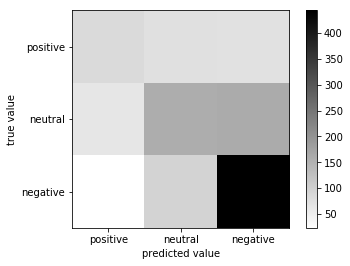

In [107]:
plt.figure()
plt.imshow(mat,
               cmap=plt.cm.gray_r, interpolation='nearest')
plt.colorbar()
plt.ylabel('true value')
plt.xlabel('predicted value')
plt.xticks([0,1,2],['positive','neutral','negative'])
plt.yticks([0,1,2],['positive','neutral','negative'])
plt.savefig("confusion_matrix.png",bbox_inches = "tight")

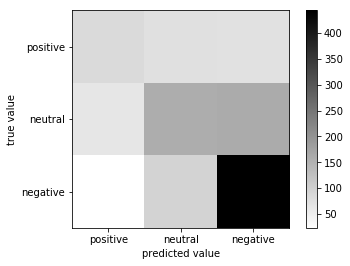

In [105]:
mat = confusion_matrix(label_test,pred_test,labels = ['positive','neutral','negative'])
plot_confusion_matrix(mat)

In [82]:
print(classification_report(label_test,pred_test))

             precision    recall  f1-score   support

   negative       0.65      0.79      0.71       563
    neutral       0.48      0.41      0.44       385
   positive       0.49      0.36      0.42       233

avg / total       0.57      0.58      0.57      1181



In [18]:
df_sub = pd.read_csv('../Feelings/tweets_submission.csv')

In [19]:
tweets_sub = [handle_emojis(tweet) for tweet in df_sub.text.values]
tweets2_sub = [processTweet2(tweet) for tweet in tweets_sub]
tweets3_sub = [' '.join(preprocess_word(remove_accents(word) )for word in tweet.split(' ')) for tweet in tweets2_sub]
df_sub.text = tweets3_sub
sno = nltk.stem.SnowballStemmer('spanish')
tweet_1_sub = [' '.join(sno.stem(word) for word in tweet.split(' ')) for tweet in df_sub.text.values]
lemma = nltk.wordnet.WordNetLemmatizer()
tweet_2_sub = [' '.join(lemma.lemmatize(word,pos='v') for word in tweet.split(' ')) for tweet in tweet_1_sub]
df_sub.text = [line.strip(' ') for line in tweet_2_sub]
count_vect = CountVectorizer(vocabulary=voc,ngram_range=(1,2),token_pattern=r'\b\w+\b')
X_test_counts = count_vect.fit_transform(df_sub.text.values)
X_test_counts = X_test_counts.toarray()
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
extra_tomerge = get_1hot_hourAirlineEmoji(df_sub)
all_matrix = np.column_stack((X_test_tfidf.toarray(),extra_tomerge.values))
all_matrix_2 = np.c_[all_matrix,df_sub['is_reply'].apply(is_reply).values]

In [20]:
prediction = model.predict(all_matrix_2)

In [21]:
prediction

array([[9.9999976e-01, 8.9718448e-08, 8.7793708e-08],
       [2.1490701e-03, 5.6678727e-02, 9.4117224e-01],
       [9.9999988e-01, 1.0547088e-07, 3.8558809e-08],
       ...,
       [9.9999738e-01, 2.5320796e-06, 1.7602167e-07],
       [9.9999988e-01, 6.9616462e-08, 2.1587840e-10],
       [8.0059353e-06, 9.9987352e-01, 1.1846994e-04]], dtype=float32)

In [22]:
pred = encoder.inverse_transform(prediction)

In [23]:
def create_submit_file(df_submission, ypred):
    date = datetime.now().strftime("%m_%d_%Y-%H_%M_%S")
    filename = 'submission_' + date + '.csv'

    df_submission['airline_sentiment'] = ypred
    df_submission[['tweet_id','airline_sentiment']].to_csv(filename,index_label = False,index = False)

    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')
#prediction[prediction == 0] = "negative"
#prediction[prediction == 1] = "neutral"
#prediction[prediction == 2] = "positive"
create_submit_file(df_sub,pred)

Submission file created: submission_06_14_2018-18_32_00.csv
Upload it to Kaggle InClass
